In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/Users/Lauren/Voytek/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')


# imports
import os
import numpy as np
import scipy as sp
import scipy.io as io
import matplotlib.pyplot as plt

import neurodsp as ndsp
from scv_funcs import lfpca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data preprocessing
Spectrogram is computed in two ways: whole-recording and trial-epoched. 
- For whole-recording (all), spectrogram is computed as normal, i.e. non-overlaping sliding window.
- For trial-epoched, 1-second of data immediately preceding (pre) and following (move) the onset of movement is grabbed, and a PSD is computed (effectively Hamming windowed FFT). Trial type information (which finger) and whether there was trial overlap during both pre and move period is stored.

In [38]:
def lfpca_kjm(data_path, subj, fs, analysis_param):
    # load data & trial info
    stim_info = io.loadmat(data_path+'data/'+subj+'/'+subj+'_stim.mat', squeeze_me=True)
    data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)
    ecog = data['data'].T
    
    trial_inds = np.where(np.diff((stim_info['stim']>0).astype(int))==1)[0]+1
    trial_type = stim_info['stim'][trial_inds]

    win_len = int(fs)
    num_chan = ecog.shape[0]
    num_trials = len(trial_inds)
    max_freq = analysis_param['max_freq']

    # pre-initialize arrays
    psd_precomp = np.zeros((num_chan, max_freq, num_trials, 2))
    pre_overlap = np.zeros(num_trials)
    post_overlap = np.zeros(num_trials)

    # precompute trial PSDs
    for tr, ind in enumerate(trial_inds):
        # pre-movement
        f_axis, p_ = ndsp.spectral.psd(ecog[:,ind-win_len:ind], Fs=fs, nperseg=win_len)        
        psd_precomp[:,:,tr,0] = p_[:,:max_freq]
        pre_overlap[tr] = 1-np.all(stim_info['stim'][ind-win_len:ind]<1)
        # movement
        f_axis, p_ = ndsp.spectral.psd(ecog[:,ind:ind+win_len], Fs=fs, nperseg=win_len)
        psd_precomp[:,:,tr,1] = p_[:,:max_freq]
        post_overlap[tr] = 1-np.all(stim_info['stim'][ind:ind+win_len]==stim_info['stim'][ind])

    print('%i trials; %i pre-movement overlap; %i post-movement overlap'%(num_trials,pre_overlap.sum(), post_overlap.sum()))

    lfpca_all = []
    for i in range(2):
        mov_lfpca = lfpca.LFPCA(analysis_param)
        mov_lfpca.populate_fourier_data(psd_precomp[:,:,:,i], fs, f_axis)
        mov_lfpca.compute_psd()
        mov_lfpca.compute_scv()
        lfpca_all.append(mov_lfpca)
    
    # return the pre- and during-movement lfpca data, and trial info
    return lfpca_all, np.array([trial_type, pre_overlap, post_overlap])

def plot_contrast(lfpca_all, elec_def, elec_loc, labels, savepath):
    for chan in range(lfpca_all[0].numchan):
        for ind, lf in enumerate(lfpca_all):
            # PSD
            plt.subplot(1,3,1)
            plt.loglog(lf.f_axis,lf.psd[chan,:], alpha=0.5)
            plt.xlim([1,200])
            plt.ylabel('PSD')
            try:
                plt.title(elec_def[elec_loc[chan].astype(str)])
            except:
                plt.title('others')
            # SCV
            plt.subplot(1,3,2)
            plt.loglog(lf.f_axis,lf.scv[chan,:], alpha=0.5)
            plt.ylabel('SCV')
            plt.xlim([1,200])
            plt.ylim([0.5, 5])
            # p-val
            plt.subplot(1,3,3)
            plt.loglog(lf.f_axis,lf.ks_pvals[chan,:], alpha=0.5)
            plt.ylabel('KS p-val')
            plt.xlim([1,200])
            plt.ylim([1e-7, 1])
            
        plt.legend(labels)
        # draw unity line for SCV and p<0.01 for p-val
        plt.subplot(1,3,2)
        plt.loglog(lf.f_axis,np.ones_like(lf.f_axis), 'k--', alpha=0.5)
        plt.subplot(1,3,3)
        plt.loglog(lf.f_axis,0.01*np.ones_like(lf.f_axis), 'k--', alpha=0.5)
        plt.tight_layout()
        # save out
        plt.savefig(savepath + '_' + str(chan) + '.png')
        plt.clf()
        

In [39]:
# define data folder
data_path = '/Users/rdgao/Documents/data/ECoG_KJM/digit/'
saveout_path = '../results/kjm_digits/'
save_files = ['pre','move','whole']
subjs = ['bp', 'cc', 'ht', 'jc', 'jp', 'mv', 'wc', 'wm', 'zt']

# electrode location
elec_def = {
    '1': 'dorsal M1',
    '3': 'dorsal S1',
    '4': 'ventral S1+M1',
    '6': 'frontal (non-R)',
    '7': 'parietal (non-R)',
    '8': 'temporal',
    '9': 'occipital'
}

In [40]:
fs = 1000.
# lfpca params
analysis_param = {'nperseg': 1000,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

for subj in subjs:
    print(subj)
    # get the trial-separated LFPCA
    lfpca_all, trial_info = lfpca_kjm(data_path,subj,fs,analysis_param)
    
    # get LFPCA for whole recording
    data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)    
    lfpca_all.append(lfpca.LFPCA(analysis_param))
    lfpca_all[-1].populate_ts_data(data['data'].T, fs)
    lfpca_all[-1].compute_all_spectral()
    
    # make dir
    subj_path = saveout_path+subj+'/'
    if not os.path.isdir(subj_path):
        os.mkdir(subj_path)
    
    print('Computing exponential KS test...')
    for ind, lf in enumerate(lfpca_all):
        # compute fit
        lf.compute_KS_expfit()
        # save out LFPCA         
        lf.save_spec_vars(subj_path+save_files[ind]+'.npz', save_spg=True)
    
    # save trial info and plot contrast
    np.savez(subj_path+'trial_info.npz', trial_info=trial_info, elec_regions=data['elec_regions'])
    
    figure_savepath = saveout_path+'scv_figs/'+subj    
    plt.figure(figsize=(15,5))
    plot_contrast(lfpca_all, elec_def, data['elec_regions'], save_files, figure_savepath)

bp
148 trials; 8 pre-movement overlap; 1 post-movement overlap
Computing exponential KS test...


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cc
151 trials; 36 pre-movement overlap; 2 post-movement overlap
Computing exponential KS test...
ht
151 trials; 24 pre-movement overlap; 1 post-movement overlap
Computing exponential KS test...
jc
132 trials; 4 pre-movement overlap; 2 post-movement overlap
Computing exponential KS test...
jp
118 trials; 92 pre-movement overlap; 9 post-movement overlap
Computing exponential KS test...
mv
31 trials; 21 pre-movement overlap; 1 post-movement overlap
Computing exponential KS test...
wc
154 trials; 58 pre-movement overlap; 4 post-movement overlap
Computing exponential KS test...
wm
91 trials; 22 pre-movement overlap; 15 post-movement overlap
Computing exponential KS test...
zt
149 trials; 62 pre-movement overlap; 2 post-movement overlap
Computing exponential KS test...


### old code below (pre-lfpca)

### spectral PCA

In [7]:
from sklearn.decomposition import PCA

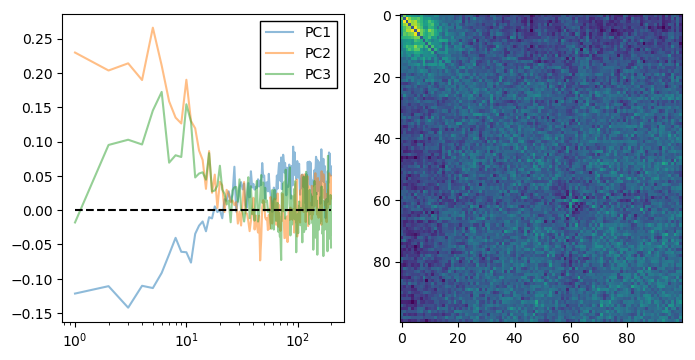

In [33]:
num_freq = 100
chan = 0
f_axis, t_axis, spg = sp.signal.spectrogram(ecog[:,chan], fs=fs, nperseg=int(fs), noverlap=0)
pca = PCA(n_components=3)
pca.fit(np.log10(np.abs(spg**2).T))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogx(f_axis[1:200],pca.components_[:,1:200].T, alpha=0.5)
plt.plot([1,200], [0,0], 'k--')
plt.legend(('PC1', 'PC2', 'PC3'))

plt.subplot(1,2,2)
plt.imshow(sp.corrcoef(np.log10(np.abs(spg**2)))[:num_freq,:num_freq]*(np.ones((num_freq, num_freq))-np.eye(num_freq)))
#plt.colorbar()

### save out all PSD and SCV plots

In [159]:
data_path = '/Users/rgao/Documents/Data/ECoG_KJM/digit/'
subjs = ['bp', 'cc', 'ht', 'jc', 'jp', 'mv', 'wc', 'wm', 'zt']
elec_regios = {
    '1': 'dorsal M1',
    '3': 'dorsal S1',
    '4': 'ventral S1+M1',
    '6': 'frontal (non-R)',
    '7': 'parietal (non-R)',
    '8': 'temporal',
    '9': 'occipital'
}

plt.figure(figsize=(8,4))
for subj in subjs: 
    print(subj)
    data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)
    ecog = data['data']
    fs = 1000.
    num_samp, num_chan = np.shape(ecog)
    # compute PSD
    freqs, psd_mean = ndsp.spectral.psd(ecog.T,Fs=fs, method='mean')
    _, psd_med = ndsp.spectral.psd(ecog.T,Fs=fs, method='median')
    scv = np.zeros((int(fs/2+1), num_chan))
    for chan in range(num_chan):
        freqs, scv[:,chan] = ndsp.spectral.scv(ecog[:,chan], Fs=fs)
        try:
            ele_name = elec_regios[str(data['elec_regions'][chan])]
        except:
            ele_name = 'others'

        # make & save plots
        plt.subplot(1,2,1)
        plt.loglog(freqs[:200], psd_mean[chan,:200].T, lw=1, alpha=0.5)
        plt.loglog(freqs[:200], psd_med[chan,:200].T, lw=1, alpha=0.5)
        plt.legend(('mean welch', 'med welch'))
        plt.subplot(1,2,2)
        plt.loglog(freqs[:300], scv[:300, chan], 'k', lw=1, alpha=0.5)
        plt.legend([ele_name])
        plt.plot([1,200], [1,1], 'k--')
        plt.plot([100,100], [0.5,4], 'k--');
        plt.xlim([1, 300])
        plt.ylim([0.5, 4])
        plt.tight_layout()
        # save out
        plt.savefig(data_path+'/scv_figs/'+subj+'_' + str(chan) + '.png')
        plt.clf()

bp
cc
ht
jc
jp
mv
wc
wm
zt
